# **HOPFIELD NETWORKS**

### *What is a hopfield network?*
#### A hopfield network is a type of recurrent neural network (RNN) great for creating and studing models of associative memory. Comprised of nodes (or neurons) and edges, a hopfield network will store relationship information about its nodes in the edges between its nodes. 

#### In a hopefield network, each node/neuron has the ability to "fire" and activate or remain inactive. This is often denoted as -1 or 1. For a given event, the activation states between any nodes i and j in the network can also be compared and is termed as the interaction w_ij. This also takes on the value 1 or -1, indicating a positive or negative correlation between the states of nodes during an event (NOTE: this does not indicate both nodes firing or not, it only indicates if the nodes compared behave the same at the same time). If multiple events occur allowing nodes to have a new activation state at each event, then the interactions between nodes at each event can be summed and stored in a given edge between any two nodes. This ability to store the interactions between nodes is critical for creating the memory capabilities of the network. 

### *Overview*

#### In this walkthrough, we will be working with two types of data: images of numbers in a hand-drawn style, and random patterns. These images will be compiled with other images of the same dimension to form arrays of images, which will then be fed into our network. All pixels will be confined to be either a 1 state or -1 state, resulting in images of only two colors.

#### To simplify data processing and hopefield network generation, our 2D images will be converted to a 1D vector. These vectors will then be fed into a function that will generate a full-edged hopfield network. In this network, every node will correspond to a pixel location for a set of images.  

#### It might be useful to think of this model in terms of neurons and the brain. Lets say we have ten unique images of 7x7 pixels and each pixel location of an image corresponds to a given neuron. Since a pixel can either be a 1 or a -1 in value in a given image, we can consider the neuron at that location to be either active or not active. 

#### In our 10 images, we might expect to see some neurons fire occasionly, some neurons to always fire, and others to maybe never fire at all. When a given neuron is observed in relation to another neuron accross all images, the relationships between their activations can be collected. In our case we sum them, and create an aggregate relationship between those two neurons. 

#### Lets say neuron A (top right pixel of an image) and neuron B (top left pixel of an image) behave the same (fire or don't fire together) for 8 of the 10 images, and behave differently for the remaining 2 images. If an interaction of 1 means neurons fire together and -1 indicates firing seperatly, we could get the set of interactions: [1, -1, 1, 1, 1, 1, 1, 1, 1, -1]. Summed together we get 1 + (-1) + 1 + 1 + 1 + 1 + 1 + 1 + 1 + (-1) = 6. The two neurons positively correlate! Thus the w_AB edge between node A and node B in our hopfield network will then contain a vaule of 6 (or 6/(7x7) if we normalize). If the resulting edge was negative, the two neurons would negatively correlate. these correlation values will define our hopfield network, providing relationship weights between neurons.

### *The weight matrix*

#### Mathematically, we can think of these correlation weights as a matrix, where a given weight corresponds to a given edge between nodes in our hopfield network (e.g. edge between node A and node B would be row A and row B of the matrix). This matrix will also contain zeros in the diagnal as it would not make sense for a node to ever interact and correlate with itself, and be symmetrical. 

#### These weight matrices can either be full (all edges present in the network) or have varying degrees of sparcity, as edges are removed from the hopfield network. We will look into how edge pruning of hopfield networks affect their ability to function reconstruct the images they "remember" and store within them. 

### *Reconstruction*


### *The Question*

### 1) Import dependencies

In [265]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import seaborn as sns
sns.set_palette('hls', 10)

### 2) Define necessary functions
##### For the reconstruct image function, the weight variable specifies a given hopfield network to reconstruct the image with.

In [412]:
############################################################################################################
### Functions to set up images as 1-D vectors or generate 
### Images to vectors based on pixel value cut-off of 128. Converts all pixels of image to only 2 possible colors, (e.g. black and white)

# Set up images as 1-D vectors from specified path
def image_to_np(path):
    img = Image.open(path)
    img_np = np.asarray(img)
    try:
        img_np = img_np[:, :, 0]
    except IndexError:
        pass
    img_np = np.where(img_np<128, -1, 1)
    img_np = img_np.reshape(N)
    return img_np

# Set up images as 1-D vectors from specific MNIST number dataset
def img_to_vec_MNIST(index):
    img = X_train[index]
    img_vec = np.asarray(img)
    try:
        img_vec = img_vec[:, :, 0]
    except IndexError:
        pass
    img_vec = np.where(img_vec<128, -1, 1)
    img_vec = img_vec.reshape(N)
    return img_vec

############################################################################################################
### Function to generate images of random pixels

# Generating random image patterns of a provided dimension (n*n)
def gen_pattern_vec(dim, num_indices = 0):
    pattern = np.ones((dim))
    num_indices = dim // 2
    init_indices = np.random.choice(np.arange(dim), replace = False, size = (num_indices))
    pattern[init_indices] = -1
    return pattern


############################################################################################################
### Functions for generating various Hopfield Networks

# Full edge Hopfield, based on patterns/images selected and number of nodes/pixels in image
def fully_connected(pattern, nodes):
    w = np.zeros((nodes, nodes))
    h = np.zeros((nodes))
    for i in tqdm(range(nodes)):
        for j in range(nodes):
            for p in range(len(pattern)):
                w[i, j] += (pattern[p, i]*pattern[p, j]).sum()
            if i==j:
                w[i, j] = 0
    w /= nodes
    return w

# Threshold Pruned Hopfield, based on an input full hopfield network, number of nodes/pixels, and percentile magnitude cutoffs of edges
def pruned_hopfield(full_weight, nodes, thresh): 
    edge_mat = np.zeros(shape=(nodes,nodes))
    for i in range(nodes):
        for j in range(nodes):
            if i==j:
                edge_mat[i,j] = 0
            else:
                edge_mat[i,j] = 1           
    for i in tqdm(range(nodes)):
        for j in range(nodes):
            if abs(full_weight[i,j]) < thresh:
                edge_mat[i,j] = 0           
    w_pruned = np.zeros((nodes, nodes))
    for i in range(nodes):
        for j in range(nodes):
            w_pruned[i,j] = full_weight[i,j]*edge_mat[i,j]
    return w_pruned

# Randomly Pruned Hopfield, based on an input full hopfield network, number of nodes/pixels, and percent of edges to remove
def random_hopfield(full_weight, nodes, percent):
    edge_mat = np.zeros(shape=(nodes,nodes))
    for i in range(nodes):
        for j in range(nodes):
            if i==j:
                edge_mat[i,j] = 0
            else:
                edge_mat[i,j] = 1
    for i in tqdm(range(nodes)): 
        for j in range(nodes):
            if i < j:
                if random.uniform(0, 1) < percent:
                    edge_mat[i,j] = 0
    for i in tqdm(range(nodes)): 
        for j in range(nodes):
            if j > i:
                edge_mat[j,i] = edge_mat[i,j]
    w__rand_pruned = np.zeros((nodes, nodes))
    for i in range(len(full_weight)):
        for j in range(len(full_weight)):
            w__rand_pruned[i,j] = full_weight[i,j]*edge_mat[i,j]
    return w__rand_pruned   


############################################################################################################
### Function for reconstructing patterns/images from a given hopfield network

# Reconstructing patterns/images using specified hopfield network (weight), test patterns, iterations, number of nodes/pixels, the full pattern datset, and boolean (for plotting option)  
def reconstruct(weight, test_data, num_iter, nodes, pattern, plotting_bool):
    N_sqrt = np.sqrt(nodes).astype('int32')
    if plotting_bool == True:
        fig = plt.figure(figsize = (8, 8))
    hamming_distance = np.zeros((num_iter, len(pattern)))
    h = np.zeros((nodes))
    for iteration in tqdm(range(num_iter)):
        for i in range(nodes):
            i = np.random.randint(nodes)
            h[i] = 0
            for j in range(nodes):
                h[i] += weight[i, j]*test_data[j]
        new_data = np.where(h<0, -1, 1)
        for i in range(len(pattern)):
            hamming_distance[iteration, i] = ((pattern - new_data)[i]!=0).sum()
        if plotting_bool == True:
            plt.subplot(5, 5,iteration+1)
            plt.imshow(np.where(new_data.reshape(N_sqrt, N_sqrt)<1, 0, 1), cmap='gray')
    return new_data, hamming_distance


############################################################################################################
### Function for distorting images 

# Distort a percentage of pixels in image randomly
def dist_img_rand(array, probability):
    distort_rand = []
    for i in array:
        event = np.random.uniform(0,1)
        if event < probability:
            if i == -1:
                distort_rand.append(1)
            elif i == 1:
                distort_rand.append(-1)
        else:
            distort_rand.append(i)
    return np.asarray(distort_rand)


############################################################################################################
### Part 4, large scale trend functions

# Function to test accuracy as image distortion/noise increases + gets hamming distances
def distortion_accuracy_with_ham(weights, pattern, nodes, num_iter, num_trials, step):
    correct_avgs = []
    hamming_dist_avg = []
    percent = 0
    while percent <= 100:
        print('\n' + "Percent pixels changed: " + str(percent) + '%')
        trials = 0
        correct_bool_list = []
        hamming_dist_trial_list = []
        while trials <= num_trials:
            image_number = np.random.randint(len(pattern))
            test_array = dist_img_rand(pattern[image_number], percent*0.01)
            new_data, hamming_distance = reconstruct(weights, test_array, num_iter, nodes, pattern, False)
            last_iter = hamming_distance[-1]
            hamming_dist_trial_list.append(last_iter[image_number])
            if percent <= 50:
                computer_guess = np.where(last_iter == last_iter.min())[0][0]
            else:
                computer_guess = np.where(last_iter == last_iter.max())[0][0]
            if computer_guess == image_number:
                correct_bool_list.append(1)
            else:
                correct_bool_list.append(0)
            trials += 1
        avg_c = sum(correct_bool_list) / len(correct_bool_list)
        avg_hd = sum(hamming_dist_trial_list) / len(hamming_dist_trial_list)
        correct_avgs.append(avg_c)
        hamming_dist_avg.append(avg_hd)
        percent += step
    return correct_avgs, hamming_dist_avg

# Function to test accuracy as number of states increases + gets hamming distances
def stateNum_accuracy_with_ham(weight_type, nodes, num_iter, num_trials, step, percent_distorion, max_states):
    correct_avgs = []
    hamming_dist_avg = []
    number_of_states = 1
    while number_of_states <= max_states:
        trials = 0
        correct_bool_list = []
        hamming_dist_trial_list = []
        print('\n' + "Number of States: " + str(number_of_states))
        pattern = np.asarray([gen_pattern_vec(nodes) for _ in range(number_of_states)])
        if weight_type == 'full':
            weights = fully_connected(pattern, nodes)
        elif weight_type == 'pruned':
            full_weights = fully_connected(pattern, nodes)
            threshold_value = np.percentile(abs(full_weights), threshold_percentage)
            weights = pruned_hopfield(full_weights, nodes, threshold_value)
        elif weight_type == 'random':
            full_weights = fully_connected(pattern, nodes)
            weights = random_hopfield(full_weights, nodes, percent)
        else:
            print('weight_type needs to be either "full", "pruned", or "random".')
            return;
        while trials <= num_trials:
            image_number = np.random.randint(len(pattern))
            test_array = dist_img_rand(pattern[image_number], percent_distorion)
            new_data, hamming_distance = reconstruct(weights, test_array, num_iter, nodes, pattern, False)
            last_iter = hamming_distance[-1]
            hamming_dist_trial_list.append(last_iter[image_number])
            computer_guess = np.where(last_iter == last_iter.min())[0][0]
            if computer_guess == image_number:
                correct_bool_list.append(1)
            else:
                correct_bool_list.append(0)
            trials += 1
        avg_c = sum(correct_bool_list) / len(correct_bool_list)
        avg_hd = sum(hamming_dist_trial_list) / len(hamming_dist_trial_list)
        correct_avgs.append(avg_c)
        hamming_dist_avg.append(avg_hd)
        number_of_states += step
    return correct_avgs, hamming_dist_avg


############################################################################################################
### Useful functions

# Check if matrix is symmetric
def check_symmetric(matrix, rtol=1e-05, atol=1e-08):
    return np.allclose(matrix, matrix.T, rtol=rtol, atol=atol)

# Count Number of edges
def count_edge(weight_mat):
    count = 0
    for i in range(len(weight_mat)):
        for j in weight_mat[i]:
            if abs(j) > 0:
                count += 1
    return count/2

# Function for getting labels for each pattern (useful for graphing)
def label_generator(pattern):
    labels = []
    for i in range(len(pattern)):
        labels.append("pattern " + str(i))
    return labels


############################################################################################################

## Random Patterns

### 3.1) Generate random patterns

#### Lets see how well a network performs with random pattern images.
##### All images are 10x10 (100 pixels) and there are 10 images in total. 
##### Feel free to change n and P and see how these variables affect the algorithm! (NOTE: increasing n past 40 may take extremly long)

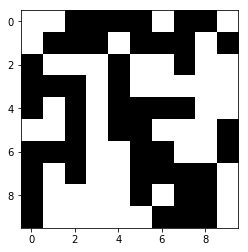

In [413]:
# Random pattern generation and Hopfield
n = 10
N = n*n
P = 10

PATTERN = np.asarray([gen_pattern_vec(N) for _ in range(P)])


# Show a random pattern example
plt.imshow(PATTERN[8].reshape(n, n), cmap='gray')
plt.show()

### 3.2) Generate hopfield networks
#### Weight matrices are made for: 
##### -A full hopfield network (all weights present)
##### -An orderly pruned hopfield network (anything below the 80th percentile in weight magnitude is removed)
##### -A randomly pruned hopfield (55% of weights regardless of magnitude removed)
##### 
##### All matrices are then checked to make sure they are generated correctly, and to see number of edges present.


In [414]:
# full matrix
w = fully_connected(PATTERN, N)

# pruned via 80th percentile (everyhing below 80th percentile magnitude removed)
w_pruned = pruned_hopfield(w, N, np.percentile(abs(w), 80))

# randomly pruned (55% of edges removed)
w_random = random_hopfield(w, N, 0.55)

# checking the matrices
print("\n")
print("Are the matrices symmetric?")
print("full weight matrix: " + str(check_symmetric(w)))
print("orderly pruned weight matrix: " + str(check_symmetric(w_pruned)))
print("randomly pruned weight matrix: " + str(check_symmetric(w_random)))

print("\n")
print("Number of edges:")
print("full weight matrix: " + str(count_edge(w)))
print("orderly pruned weight matrix: " + str(count_edge(w_pruned)))
print("randomly pruned weight matrix: " + str(count_edge(w_random)))

w_flat = [item for sublist in w for item in sublist]
w_pruned_flat = [item for sublist in w_pruned for item in sublist]
w_random_flat = [item for sublist in w_random for item in sublist]

w_flat_mag = [abs(x) for x in w_flat]
w_pruned_flat_mag = [abs(x) for x in w_pruned_flat]
w_random_flat_mag = [abs(x) for x in w_random_flat]

print("\n")
print("Max edge weight magnitude in matrix:")
print("full weight matrix: " + str(max(w_flat_mag)))
print("orderly pruned weight matrix: " + str(max(w_pruned_flat_mag)))
print("randomly pruned weight matrix: " + str(max(w_random_flat_mag)))

100%|██████████| 100/100 [00:00<00:00, 84358.49it/s]



Are the matrices symmetric?
full weight matrix: True
orderly pruned weight matrix: True
randomly pruned weight matrix: True


Number of edges:
full weight matrix: 3713.0
orderly pruned weight matrix: 1785.0
randomly pruned weight matrix: 1723.0


Max edge weight magnitude in matrix:
full weight matrix: 0.1
orderly pruned weight matrix: 0.1
randomly pruned weight matrix: 0.1


### 3.3) Plot matrix weights
#### What do they look like? Are there patterns?

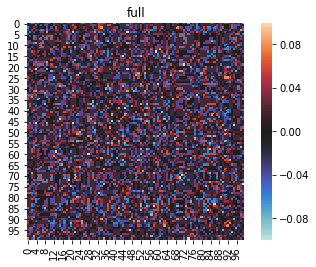

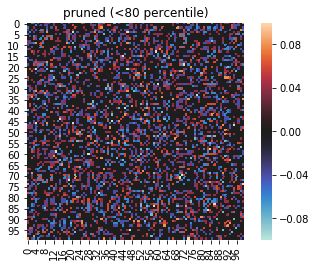

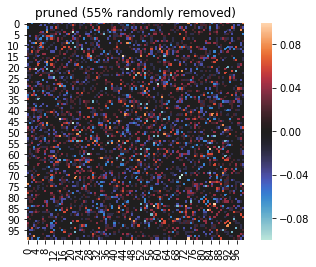

In [415]:
ax = sns.heatmap(w, center=0)
w.shape
plt.imshow(w)
plt.title("full")
plt.show()

ax = sns.heatmap(w_pruned, center=0)
w_pruned.shape
plt.imshow(w_pruned)
plt.title("pruned (<80 percentile)")
plt.show()

ax = sns.heatmap(w_random, center=0)
w_random.shape
plt.imshow(w_random)
plt.title("pruned (55% randomly removed)")
plt.show()

### 3.4) Plot hopfield network distribution of weights
#### We should expect to see weights close to 0 make up the bulk of the matrix, with higher magnitude weights quickly decreasing in count. 
#### Also, number of non-zero weights should reflect the amount removed in pruned networks.

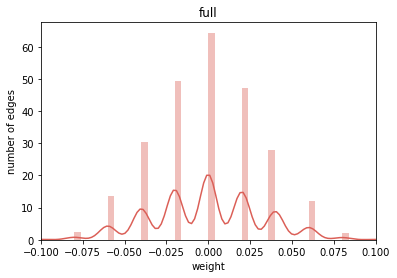

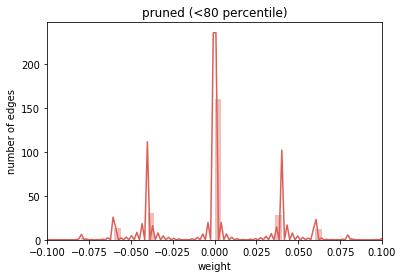

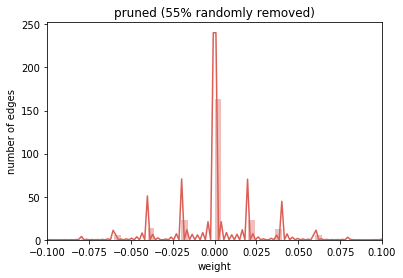

In [416]:
sns.distplot(w_flat)
plt.xlim([min(w_flat),max(w_flat)])
plt.xlabel("weight")
plt.ylabel("number of edges")
plt.title("full")
plt.show()

sns.distplot(w_pruned_flat)
plt.xlim([min(w_pruned_flat),max(w_pruned_flat)])
plt.xlabel("weight")
plt.ylabel("number of edges")
plt.title("pruned (<80 percentile)")
plt.show()

sns.distplot(w_random_flat)
plt.xlim([min(w_random_flat),max(w_random_flat)])
plt.xlabel("weight")
plt.ylabel("number of edges")
plt.title("pruned (55% randomly removed)")
plt.show()

### 3.5) Create test data to distort and reconstruct
#### An image from our given set of random patterns will undergo distortion with 20% of its pixels randomly changing states.

Image chosen: Image 5


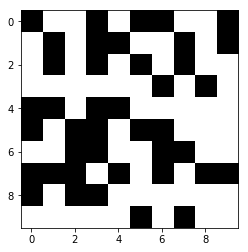

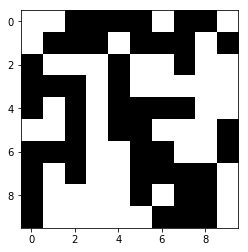

In [417]:
#Select a test data image to mess up
image_num = random.randint(0, P-1)
print("Image chosen: Image", image_num)

#percent noise to add to test data
pct_noise = 0.2
dist_per = PATTERN[image_num]
dist_per = dist_img_rand(dist_per, pct_noise)

# compare distorted to original shape
test_array = dist_per
plt.imshow(test_array.reshape(n, n), cmap='gray')
plt.show()
plt.imshow(PATTERN[8].reshape(n, n), cmap='gray')

### 3.6) Reconstruct original image using our hopfield networks
#### Using 5 iterations of pixel re-shuffling, our hopfield network attempts to fix the distorted image back to the state it "remembers".
##### In order of full, pruned (<80 percentile), and pruned (55% randomly removed)

100%|██████████| 5/5 [00:00<00:00, 82.71it/s]


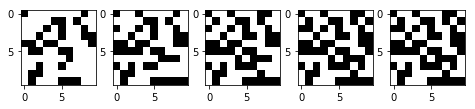

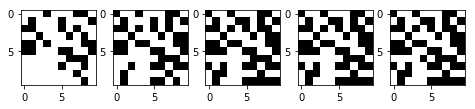

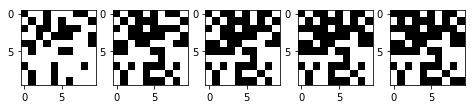

In [418]:
new_data_full, hamming_distance_full = reconstruct(w, test_array, 5, N, PATTERN, True)
new_data_pruned, hamming_distance_pruned = reconstruct(w_pruned, test_array, 5, N, PATTERN, True)
new_data_rand, hamming_distance_rand = reconstruct(w_random, test_array, 5, N, PATTERN, True)

### 3.7) Plot hamming distance
#### The reconstruction function will spit out a hamming distance between the final image and every pattern in the image dataset provided. 
##### If our networks are succesful, pattern with the lowest hamming distance should be original pattern.
##### Hamming distance expected to drop as image is reconstructed for correct pattern.

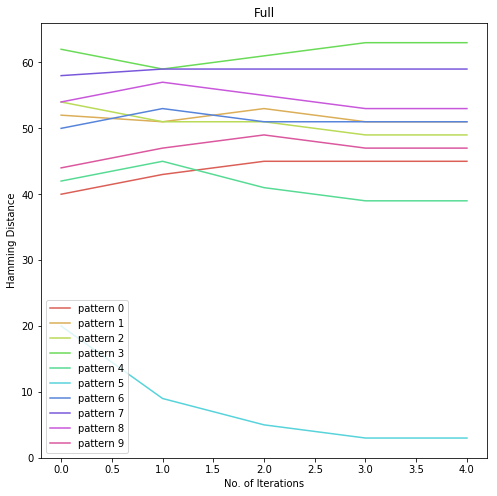

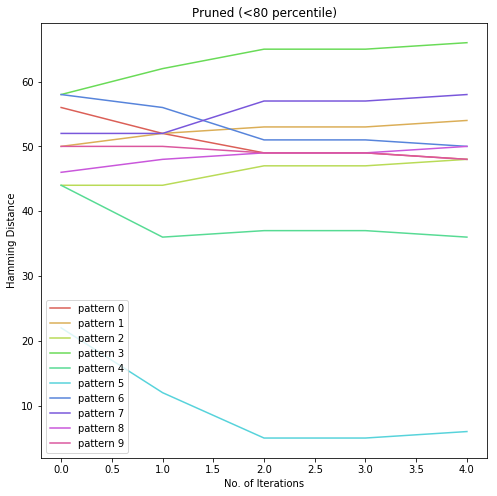

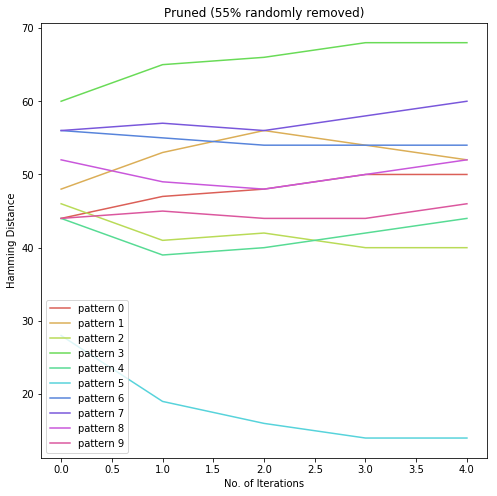

In [419]:
# Labels for graphing, tag for checking accuracy
labels = label_generator(PATTERN)

# Hamming distance plotting of each pattern (full network)
fig = plt.figure(figsize = (8, 8))
plt.plot(hamming_distance_full)
plt.title("Full")
plt.xlabel('No. of Iterations')
plt.ylabel('Hamming Distance')
plt.legend(labels,  loc='best')
plt.show()

# Hamming distance plotting of each pattern (pruned 80th percentile)
fig = plt.figure(figsize = (8, 8))
plt.plot(hamming_distance_pruned)
plt.title("Pruned (<80 percentile)")
plt.xlabel('No. of Iterations')
plt.ylabel('Hamming Distance')
plt.legend(labels,  loc='best')
plt.show()

# Hamming distance plotting of each pattern (pruned 55% random)
fig = plt.figure(figsize = (8, 8))
plt.plot(hamming_distance_rand)
plt.title("Pruned (55% randomly removed)")
plt.xlabel('No. of Iterations')
plt.ylabel('Hamming Distance')
plt.legend(labels,  loc='best')
plt.show()

### 3.8) Confirm image classification successful
#### Pick pattern with lowest hamming distance. Compare chosen pattern to correct pattern.

In [420]:
# Computer picks pattern with lowest hamming distance (if % pixel change below 0.5)
last_iter_full = hamming_distance_full[-1]
computer_guess_full = np.where(last_iter_full == last_iter_full.min())
computer_guess_full[0][0]

last_iter_pruned = hamming_distance_pruned[-1]
computer_guess_pruned = np.where(last_iter_pruned == last_iter_pruned.min())
computer_guess_pruned[0][0]

last_iter_rand = hamming_distance_rand[-1]
computer_guess_rand = np.where(last_iter_rand == last_iter_rand.min())
computer_guess_rand[0][0]

# Original pattern number
print("Original image number:", image_num)
print("\n")

print("Full: ")
if computer_guess_full[0][0] == image_num:
    print("Computer guesses pattern " + str(computer_guess_full[0][0]) + ". Computer correct! :)")
else:
    print("Computer guesses pattern " + str(computer_guess_full[0][0]) + ". Computer incorrect. :(")
print("\n")

print("Pruned (<80 percentile): ")
if computer_guess_pruned[0][0] == image_num:
    print("Computer guesses pattern " + str(computer_guess_pruned[0][0]) + ". Computer correct! :)")
else:
    print("Computer guesses pattern " + str(computer_guess_pruned[0][0]) + ". Computer incorrect. :(")
print("\n")

print("Pruned (55% randomly removed): ")
if computer_guess_rand[0][0] == image_num:
    print("Computer guesses pattern " + str(computer_guess_rand[0][0]) + ". Computer correct! :)")
else:
    print("Computer guesses pattern " + str(computer_guess_rand[0][0]) + ". Computer incorrect. :(")

Original image number: 5


Full: 
Computer guesses pattern 5. Computer correct! :)


Pruned (<80 percentile): 
Computer guesses pattern 5. Computer correct! :)


Pruned (55% randomly removed): 
Computer guesses pattern 5. Computer correct! :)


## Playing With Distortion

### 4.1.1) Generate images and increasingly distort them, testing to see how reconstruction is impacted.
### *Full hopfield network*
#### Is there a level of distortion that makes it impossible for our network to reconstruct?

In [ ]:
# Increasing Distortion: Full
accuracy_for_rand_dist_20Trials_10Iter_full, dist_hd_full = distortion_accuracy_with_ham(w, PATTERN, 7*7, 15, 20, 2)

### 4.1.2) Generate images and increasingly distort them, testing to see how reconstruction is impacted.
### *Pruned (<80 percentile) hopfield network*
#### Is there a level of distortion that makes it impossible for our network to reconstruct?

In [ ]:
# Increasing Distortion: Pruned (<80 percentile)
accuracy_for_rand_dist_20Trials_10Iter_pruned, dist_hd_pruned = distortion_accuracy_with_ham(w_pruned, PATTERN, 7*7, 15, 20, 2)

### 4.1.2) Generate images and increasingly distort them, testing to see how reconstruction is impacted.
### *Pruned (55% randomly removed) hopfield network*
#### Is there a level of distortion that makes it impossible for our network to reconstruct?

In [ ]:
# Increasing Distortion: Pruned (55% randomly removed)
accuracy_for_rand_dist_20Trials_10Iter_random, dist_hd_random = distortion_accuracy_with_ham(w_random, PATTERN, 7*7, 15, 20, 2)

### 4.2) Graph hamming distances vs noise
#### How does hamming distance and computer accuracy change based on model and noise?
#### NOTE: It should be expected that after ~50% of pixel flips (full noise), hamming distances should begin to increase. This is because the new image after ~50% of pixel flips will just be the inverse of the original image

In [ ]:
x_axis = np.arange(51)*2
plt.plot(x_axis, accuracy_for_rand_dist_20Trials_10Iter_full, label='Full')
plt.plot(x_axis, accuracy_for_rand_dist_20Trials_10Iter_pruned, label='Pruned (<80 percentile)')
plt.plot(x_axis, accuracy_for_rand_dist_20Trials_10Iter_random, label='Pruned (55% randomly removed)')
plt.title("Hamming Distance Accuracy as % Pixels Change (50% is full noise)")
plt.xlabel("Percentage of Pixels Flipped")
plt.ylabel("Accuracy via Hamming Distance")
plt.legend(loc="best")
plt.show()

plt.plot(x_axis, dist_hd_full, label='Full')
plt.plot(x_axis, dist_hd_pruned, label='Pruned (<80 percentile)')
plt.plot(x_axis, dist_hd_random, label='Pruned (55% randomly removed)')
plt.title("Hamming Distance as % Pixels Change")
plt.xlabel("Percentage of Pixels Flipped")
plt.ylabel("Hamming Distance")
plt.legend(loc="best")
plt.show()

### 4.3) Graph hamming distances vs # of images "remembered"
#### How does hamming distance and computer accuracy change based on model and number of states stored in network?

In [ ]:
x_axis = np.arange(50)*2
plt.plot(x_axis, accuracy_for_increase_states_20Trials_10Iter_full, label='full')
plt.plot(x_axis, accuracy_for_increase_states_20Trials_10Iter_pruned, label='pruned (20th percentile)')
plt.plot(x_axis, accuracy_for_increase_states_20Trials_10Iter_random, label='random (80%)')
plt.title("Hamming Distance Accuracy as Number of States Increase")
plt.xlabel("Number of States")
plt.ylabel("Accuracy via Hamming Distance")
plt.legend()
plt.show()

plt.plot(x_axis, states_hd_full, label='full')
plt.plot(x_axis, states_hd_pruned, label='pruned')
plt.plot(x_axis, states_hd_random, label='random')
plt.title("Hamming Distance as Number of States Increase")
plt.xlabel("Number of States")
plt.ylabel("Hamming Distance")
plt.legend()
plt.show()